In [1]:
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from IPython.display import display_html

In [2]:
from mlxtend.plotting import plot_decision_regions
from scipy import stats

import math

from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

#KNeighborsClassifier
#LogisticRegressionClassifier
#RandomForestClassifier

In [3]:
#import pydotplus
#import graphviz

In [4]:
#!pip install nb_black
#%load_ext nb_black

In [5]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [6]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


Pulling in weather data from Openweather.org. URL: https://home.openweathermap.org/history_bulks/new

In [7]:
weather = pd.read_csv('http://history.openweathermap.org/storage/2190c766ac5f9f46f1c8c871c49523ec.csv')
weather.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1461888000,2016-04-29 00:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.80,73.27,73.40,75.96,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1461891600,2016-04-29 01:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.85,72.05,73.40,76.05,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
2,1461895200,2016-04-29 02:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.81,73.09,73.40,75.78,...,240,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
3,1461898800,2016-04-29 03:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.65,72.23,72.76,75.67,...,230,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
4,1461902400,2016-04-29 04:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.56,71.44,72.60,75.44,...,230,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   986 non-null    int64  
 1   dt_iso               986 non-null    object 
 2   timezone             986 non-null    int64  
 3   city_name            986 non-null    object 
 4   lat                  986 non-null    float64
 5   lon                  986 non-null    float64
 6   temp                 986 non-null    float64
 7   feels_like           986 non-null    float64
 8   temp_min             986 non-null    float64
 9   temp_max             986 non-null    float64
 10  pressure             986 non-null    int64  
 11  sea_level            0 non-null      float64
 12  grnd_level           0 non-null      float64
 13  humidity             986 non-null    int64  
 14  wind_speed           986 non-null    float64
 15  wind_deg             986 non-null    int

In [9]:
weather["dt_iso"] = weather["dt_iso"].map(lambda x: str(x)[:-4])

In [10]:
# changing to datetime format
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [11]:
# keeping important weather data for merge
weather2 = weather[['dt_iso', 'feels_like', 'weather_main']]

In [12]:
weather2 = weather2.rename(columns={'dt_iso':'AppointmentDay'})

In [13]:
weather2["appt_hour"] = weather2["AppointmentDay"].dt.hour

In [14]:
weather2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   AppointmentDay  986 non-null    datetime64[ns, UTC]
 1   feels_like      986 non-null    float64            
 2   weather_main    986 non-null    object             
 3   appt_hour       986 non-null    int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(1)
memory usage: 30.9+ KB


In [15]:
weather2.head()

,AppointmentDay,feels_like,weather_main,appt_hour
0,2016-04-29 00:00:00+00:00,73.27,Clouds,0
1,2016-04-29 01:00:00+00:00,72.05,Clouds,1
2,2016-04-29 02:00:00+00:00,73.09,Clouds,2
3,2016-04-29 03:00:00+00:00,72.23,Clouds,3
4,2016-04-29 04:00:00+00:00,71.44,Clouds,4


In [16]:
weather2.feels_like = weather2.feels_like.astype(int).round(0)

In [17]:
weather.weather_main.value_counts()

Clouds          574
Clear           390
Rain             11
Mist              5
Smoke             4
Thunderstorm      1
Fog               1
Name: weather_main, dtype: int64

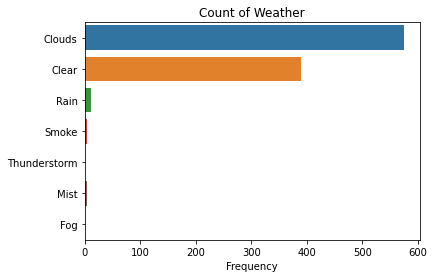

In [18]:
sns.countplot(y='weather_main', data=weather)
plt.title('Count of Weather')
plt.xlabel('Frequency')
plt.ylabel('')
plt.show()

In [19]:
#sns.catplot(x='Diabetes', hue="Handcap", col="No-show",
#                data=df, kind="count",
#                height=4, aspect=.7);

In [20]:
df = pd.read_csv('noshowappointments.csv')

Data Dictionary - The goal is to predict whether a given patient will not show up to their appointment. 

PatientId -Identification of a patient

AppointmentID - Identification of each appointment

Gender - Male or Female

AppointmentDay - The day of the actual appointment, when they have to visit the doctor

ScheduledDay - The day someone called or registered the appointment, this is before appointment of course.

Age - Age of the patient.

Neighborhood - Where the appointment takes place.

Scholarship - True of False. Whether or not the school age patient is participating in Bolsa Famila which pays a stipend based on meeting certain metrics like class attendance or getting vaccinated. 
https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

Hypertension - True or False

Diabetes -True or False

Alcoholism - True or False

Disability - 0-4. 0 is no disability and remaining numbers indicate how many disabilities the patient has

Reminder - True or False. 1 or more messages sent to the patient

No-show - True or False

# Things to do:
  *  Break down both dates into hour and day of week to see if there is anything significant with target.
  
  
  *  Check for outliers and missing data.  None but we do have imbalanced classes.
  
  
  *  Investigate whether any variables can be mixed such as Hypertenion and Diabetes.
  
  
  *  Attempt to bring in weather for the appointment day since that is likely to have an impact on target.
  
  
  *  Determine which vars are correlated with target and drop those not important.
  
  
  *  Find important variables that help predict whether a patient shows to their appointment. 
  
  
  *  Compare different models. KNN is best using continous data so it's ruled out here. 

In [21]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [22]:
weather2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   AppointmentDay  986 non-null    datetime64[ns, UTC]
 1   feels_like      986 non-null    int32              
 2   weather_main    986 non-null    object             
 3   appt_hour       986 non-null    int64              
dtypes: datetime64[ns, UTC](1), int32(1), int64(1), object(1)
memory usage: 27.1+ KB


In [23]:
df.shape

(110527, 14)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [25]:
df['AppointmentID'].nunique()

(5638433.2, 5676445.9]      25948
(5676445.9, 5714458.6]      24404
(5714458.6, 5752471.3]      19104
(5752471.3, 5790484.0]      14735
(5600420.5, 5638433.2]      13031
(5562407.8, 5600420.5]       6335
(5524395.1, 5562407.8]       3513
(5486382.4, 5524395.1]       1270
(5410357.0, 5448369.7]       1083
(5448369.7, 5486382.4]        701
(5372344.3, 5410357.0]        162
(5334331.6, 5372344.3]         83
(5296318.9, 5334331.6]         48
(5106255.4, 5144268.1]         48
(5220293.5, 5258306.2]         24
(5258306.2, 5296318.9]         19
(5144268.1, 5182280.8]         13
(5182280.8, 5220293.5]          5
(5029469.745, 5068242.7]        1
(5068242.7, 5106255.4]          0
Name: AppointmentID, dtype: int64

In [26]:
#dropping and appointmentID

df = df.drop(columns = 'AppointmentID')

In [27]:
df.head(50)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [31]:
# cleaning column names

df['Neighborhood'] = df['Neighbourhood']
df = df.drop(columns=['Neighbourhood'])

df['Hypertension'] = df['Hipertension']
df = df.drop(columns=['Hipertension'])

df['Disability'] = df['Handcap']
df = df.drop(columns=['Handcap'])

df['Reminder'] = df['SMS_received']
df = df.drop(columns=['SMS_received'])

df['no_show'] = df['No-show']
df = df.drop(columns=['No-show'])

In [32]:
df.tail()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Disability,Reminder,no_show
110522,2.572134e+12,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,0,0,0,MARIA ORTIZ,0,0,1,No
110523,3.596266e+12,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,0,0,0,MARIA ORTIZ,0,0,1,No
110524,1.557663e+13,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,0,0,0,MARIA ORTIZ,0,0,1,No
110525,9.213493e+13,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,0,0,0,MARIA ORTIZ,0,0,1,No
110526,3.775115e+14,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,0,0,0,MARIA ORTIZ,0,0,1,No


Converting to datetime data type.

In [33]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [34]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [35]:
# creating date variables from ScheduleDay

df["sch_hour"] = df["ScheduledDay"].dt.hour
df["sch_weekday_num"] = df["ScheduledDay"].dt.weekday
df["sch_weekday_name"] = df["ScheduledDay"].dt.day_name()

In [36]:
# creating date variables from AppointmentDay

df["appt_hour"] = df["AppointmentDay"].dt.hour
df["appt_weekday_num"] = df["AppointmentDay"].dt.weekday
df["appt_weekday_name"] = df["AppointmentDay"].dt.day_name()
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Disability,Reminder,no_show,sch_hour,sch_weekday_num,sch_weekday_name,appt_hour,appt_weekday_num,appt_weekday_name
0,2.987250e+13,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,0,0,No,18,4,Friday,0,4,Friday
1,5.589978e+14,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,0,0,No,16,4,Friday,0,4,Friday
2,4.262962e+12,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,0,0,No,16,4,Friday,0,4,Friday
3,8.679512e+11,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,0,0,No,17,4,Friday,0,4,Friday
4,8.841186e+12,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,0,0,No,16,4,Friday,0,4,Friday


In [37]:
# merging df and weather2 dataframes

df_merge = pd.merge(df, weather2, on='AppointmentDay', how='left', indicator=True)

In [38]:
df_merge.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,...,sch_hour,sch_weekday_num,sch_weekday_name,appt_hour_x,appt_weekday_num,appt_weekday_name,feels_like,weather_main,appt_hour_y,_merge
0,2.987250e+13,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,...,18,4,Friday,0,4,Friday,73,Clouds,0,both
1,5.589978e+14,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,...,16,4,Friday,0,4,Friday,73,Clouds,0,both
2,4.262962e+12,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,...,16,4,Friday,0,4,Friday,73,Clouds,0,both
3,8.679512e+11,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,...,17,4,Friday,0,4,Friday,73,Clouds,0,both
4,8.841186e+12,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,...,16,4,Friday,0,4,Friday,73,Clouds,0,both


In [39]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   PatientId          110527 non-null  float64            
 1   Gender             110527 non-null  object             
 2   ScheduledDay       110527 non-null  datetime64[ns, UTC]
 3   AppointmentDay     110527 non-null  datetime64[ns, UTC]
 4   Age                110527 non-null  int64              
 5   Scholarship        110527 non-null  int64              
 6   Diabetes           110527 non-null  int64              
 7   Alcoholism         110527 non-null  int64              
 8   Neighborhood       110527 non-null  object             
 9   Hypertension       110527 non-null  int64              
 10  Disability         110527 non-null  int64              
 11  Reminder           110527 non-null  int64              
 12  no_show            110527 non-

In [40]:
df_merge._merge.value_counts()

both          110527
right_only         0
left_only          0
Name: _merge, dtype: int64

In [45]:
df_merge.weather_main.value_counts()

Clear     56696
Clouds    50003
Rain       3828
Name: weather_main, dtype: int64

In [54]:
# inserting weather on May 20th because there is no hour in Appointment Day to merge on. It rained all day on 20 May
# and is the only day it rained during the period in the dataset, 29 April to 8 June 2016. 
df_merge.loc[df_merge['AppointmentDay'] == '2016-05-20 00:00:00+00:00', 'weather_main'] = 'Rain'

In [ ]:
# creating interval in days between scheduled and appointment days



## Looking at target variable, no_show.

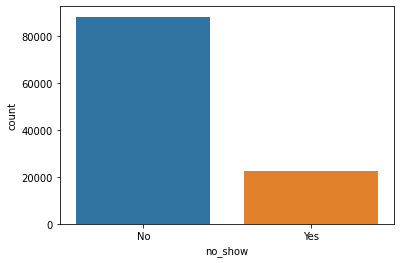

In [47]:
sns.countplot(x=df_merge['no_show'])
plt.show()

In [58]:
df_merge.no_show.value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: no_show, dtype: float64

In [57]:
df['no_show'].value_counts()

No     88208
Yes    22319
Name: no_show, dtype: int64

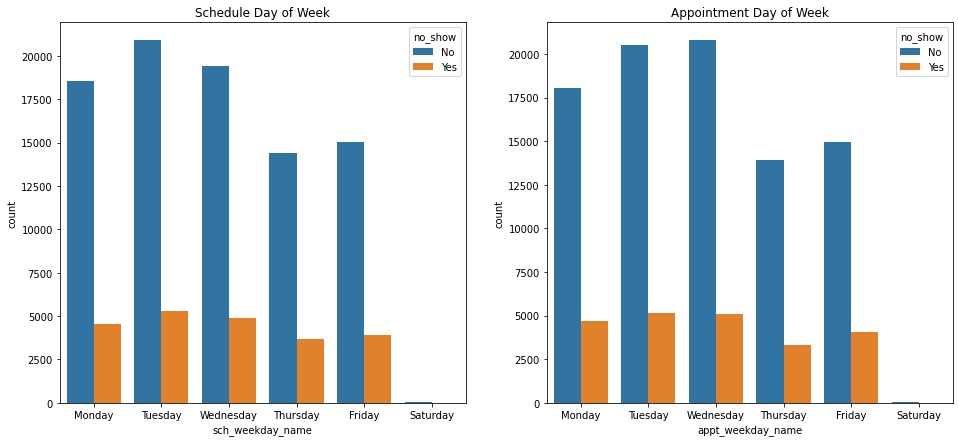

In [99]:
# Wednesday has the most obs followed by Tuesday

plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
sns.countplot(x='sch_weekday_name',hue='no_show',data=df_merge, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Schedule Day of Week')

plt.subplot(1,2,2)
sns.countplot(x='appt_weekday_name',hue='no_show',data=df_merge, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment Day of Week')
plt.show()

In [92]:
crosstable = pd.crosstab(df_merge["appt_weekday_name"], df_merge["no_show"])
crosstable

no_show,No,Yes
appt_weekday_name,,
Friday,14982,4037
Monday,18025,4690
Saturday,30,9
Thursday,13909,3338
Tuesday,20488,5152
Wednesday,20774,5093


Wednesday    25867
Tuesday      25640
Monday       22715
Friday       19019
Thursday     17247
Saturday        39
Name: appt_weekday_name, dtype: int64

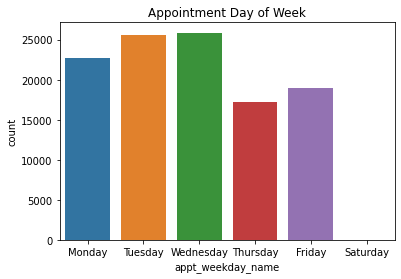

In [96]:
# Wednesday has the most appointments followed by Tuesday

sns.countplot(x=df['appt_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment Day of Week')
plt.show()

From pairplot, we can see that variables do not have a linear relationship with the target.

In [ ]:
#sns.pairplot(df)
#plt.show()

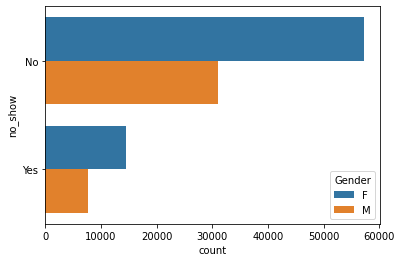

In [76]:
sns.countplot(y='no_show', hue='Gender', data=df_merge)
plt.show()

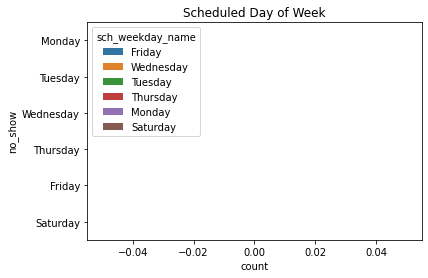

In [97]:
sns.countplot(y="no_show", hue="sch_weekday_name", data=df_merge, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.title('Scheduled Day of Week')
plt.show()

In [59]:
df_merge.groupby('no_show').mean()

,PatientId,Age,Scholarship,Diabetes,Alcoholism,Hypertension,Disability,Reminder,sch_hour,sch_weekday_num,appt_hour_x,appt_weekday_num,feels_like,appt_hour_y
no_show,,,,,,,,,,,,,,
No,1.476845e+14,37.790064,0.093903,0.073837,0.030417,0.204392,0.022742,0.291334,10.676322,1.847780,0.0,1.857439,77.166130,0.0
Yes,1.467523e+14,34.317667,0.115507,0.064071,0.030333,0.169004,0.020297,0.438371,11.162597,1.868453,0.0,1.861419,77.106994,0.0


In [ ]:
df_merge.groupby('appt_weekday_name').count

In [ ]:
df_merge.head()

In [ ]:
df.AppointmentDay.dt.month.value_counts()

In [ ]:
# to concat two strings
# df['col'] = df.column1.str.cat(df.col2, sep= ' ')

In [ ]:
df.columns

In [ ]:
weather2.columns

In [ ]:
sns.scatterplot(x="test", y="project_grade", hue="no_show", data=df)
plt.show()

In [ ]:
categorical = df_merge.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

In [ ]:
df_merge.PatientId.value_counts()

In [ ]:
df.Neighborhood.nunique()

In [ ]:
df.nunique()

In [ ]:
df.Disability.value_counts()

In [ ]:
df_merge.describe(include='all',datetime_is_numeric=True).T

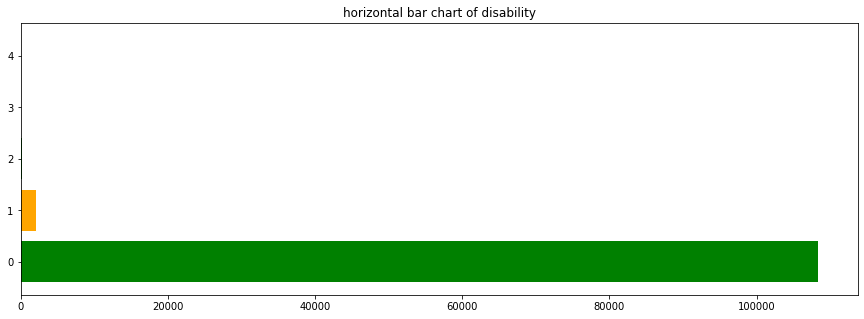

In [53]:
plt.figure(figsize=(15,5))
plt.barh(df_merge.groupby("Disability")["Disability"].count().index, 
        df_merge.groupby("Disability")["Disability"].count(), 
        color=["green","orange"])
plt.title("horizontal bar chart of disability")

plt.show()

In [ ]:
print(df.PatientId.nunique())
df.PatientId.value_counts().head(20)

In [ ]:
df.shape